# Lab 4: Diputados

El objetivo de este lab es que pongas en práctica tus habilidades de recopilación de datos usando web scraping, así como tu capacidad de analizar dichos datos ya que la información se ecuentra estructurada.

## Instrucciones
Desarrolla un programa que recopile la información de cada disputado listado en la página de gobernación: http://sitl.diputados.gob.mx/LXIV_leg/listado_diputados_buscador.php y recopila la siguiente información:

* Nombre del diputado
* Entidad que representa
* Partido político
* Correo electrónico
* Nivel de escolaridad (secundaria, preparatoria, universidad, maestría, doctorado)
* Iniciativas presentadas y estatus ante el Pleno (Tipo de presentación, totales y aprobadas)

Una vez que tengas toda la información capturada en dataframe haz un análisis basado en las siguientes puntos (tu puedes proponer más):
* Cantidad de diputados por partido político
* Niveles de escolaridad
* Niveles de escolaridad por partido político
* ¿Cómo se ve la cantidad de propuestas realizadas y aprobadas con respecto a?:
    * Partido político
    * Escolaridad

Nota: Acompaña tus análisis con plots que nutran tu análisis

In [247]:
import pandas as pd
from urllib.request import urlopen
import bs4
from bs4 import BeautifulSoup
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import uuid

In [170]:
def create_soup(url):
    source = urlopen(url).read()
    return BeautifulSoup(source)

In [171]:
gen_url = "http://sitl.diputados.gob.mx/LXIV_leg/listado_diputados_buscador.php"
gen_soup = create_soup(gen_url)
gen_soup



<!DOCTYPE html PUBLIC "-//W3C//DTD HTML 4.01 Transitional//EN" "http://www.w3.org/TR/html4/loose.dtd">

<html>
<head>
<meta content="text/html; charset=utf-8" http-equiv="Content-Type"/>
<script language="JavaScript" src="./javascripts/anim_imag.js" type="text/javascript"></script>
<link href="./include/styles_diputados.css" rel="stylesheet" type="text/css"/>
<link href="./include/formatonvo.css" rel="stylesheet" type="text/css"/>
<title>Listado de Diputados LXIV</title>
</head>
<body leftmargin="0" topmargin="0">
<table align="center" border="0" cellpadding="0" cellspacing="0">
<tr>
<td>
<tr>
<td valign="top" width="760"><img border="0" height="115" src="images/cabezal.jpg" width="760"/></td>
</tr>
<tr>
<td colspan="3">
<table border="0" cellpadding="0" cellspacing="0" width="760">
<tr>
<td align="center" bgcolor="#595843" class="textoBlanco" width="175">03/04/2022</td>
<td align="right" width="60"><a href="http://www.diputados.gob.mx" onmouseout="MM_swapImgRestore()" onmouseover="MM

In [172]:
anchor_tags = gen_soup.find_all('a', attrs={'class': 'linkVerde'})[1:]
anchor_tags[0:10]

[<a class="linkVerde" href="curricula.php?dipt=484">1 Abasolo Sánchez Pedro Daniel</a>,
 <a class="linkVerde" href="curricula.php?dipt=476">2 Acosta Peña Brasil Alberto</a>,
 <a class="linkVerde" href="curricula.php?dipt=423">3 Adame Castillo Marco Antonio</a>,
 <a class="linkVerde" href="curricula.php?dipt=250">4 Aguilar Castillo Heriberto Marcelo</a>,
 <a class="linkVerde" href="curricula.php?dipt=126">5 Aguilar Castillo Ricardo</a>,
 <a class="linkVerde" href="curricula.php?dipt=289">6 Aguilar Linda Bonifacio</a>,
 <a class="linkVerde" href="curricula.php?dipt=57">7 Aguilar Molina Leticia Arlett</a>,
 <a class="linkVerde" href="curricula.php?dipt=345">8 Aguilar Vega Marcos</a>,
 <a class="linkVerde" href="curricula.php?dipt=333">9 Aguilera Brenes Sebastián</a>,
 <a class="linkVerde" href="curricula.php?dipt=73">10 Aguilera Chairez Maribel</a>]

In [173]:
links = ['http://sitl.diputados.gob.mx/LXIV_leg/'+ anchor_tag.get('href') for anchor_tag in anchor_tags]
links[0:10]

['http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=484',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=476',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=423',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=250',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=126',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=289',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=57',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=345',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=333',
 'http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=73']

In [174]:
# helper functions
def determine_party_from_img_src(src):
    if src == 'images/LogoMorena.jpg':
        return 'Morena'
    elif src == 'images/pan.png':
        return 'PAN'
    elif src == 'images/pri01.png':
        return 'PRI'
    elif src == 'images/Logo_PT.png':
        return 'PT'
    elif src == 'images/logo_movimiento_ciudadano.png':
        return 'MC'
    elif src == 'images/encuentro.jpg':
        return 'PES'
    elif src == 'images/prd01':
        return 'PRD'
    elif src == 'images/logvrd.jpg':
        return 'Partido Verde'
    else:
        return 'Sin Partido'

def find_keys_for_initiatives(soup):
    possible_keys = [td.contents[0] for td in soup.find_all('td', attrs={'class': 'textoNegro', 'width': 150})]
    first_occurrence_of_string = possible_keys.index('TOTAL')
    keys = possible_keys[first_occurrence_of_string+1:]
    keys1 = ['Propuestas_' + key for key in keys]
    keys2 = ['Propuestas aprobadas_' + key for key in keys]
    return [keys1, keys2]

def check_studies(studies_str):
    if 'Bachillerato' in studies_str or \
        studies_str == 'Carrera Trunca' or studies_str == 'Carrera Técnica' or \
        studies_str == 'Carrera Comercial' or studies_str == 'Seminario':
        return 'Bachillerato'
    elif studies_str == 'Diplomado' or studies_str == 'Especialidad' \
        or studies_str == 'Pasante' or studies_str == 'Profesor':
        return 'Licenciatura'
    elif studies_str == 'Doctorante':
        return 'Maestría'
    elif studies_str == 'Otro' or studies_str == 'Taller': 
        return 'Sin estudios registrados'
    else:
        return studies_str

def get_studies(tds, title_tds):
    if len(tds) > 0 and len(title_tds) > 0:
        if title_tds[0].contents[0] == 'ESCOLARIDAD':
            potential_studies_1 = tds[0].contents[0]
            if potential_studies_1 == ' ':
                potential_studies_2 = tds[1].contents[0] 
                return check_studies(potential_studies_2)
            else:
                return check_studies(potential_studies_1)
        else:
            return 'Sin estudios registrados'
    else:
        return 'Sin estudios registrados'


In [175]:
# driver function to get personal data for congressperson
def get_personal_data(soup): 
    strong_tags = soup.find_all('strong')
    title_tds = soup.find_all('td', attrs={'class': 'TitulosVerde'})
    tds = soup.find_all('td', attrs={'class': 'textoNegro'})[:2]
    name = strong_tags[0].contents[0][5:]
    entity = strong_tags[2].contents[0]
    email = strong_tags[5].contents[0]
    studies = get_studies(tds, title_tds)
    party = determine_party_from_img_src(soup.find_all('img')[2].get('src'))
    return {
        'ID': uuid.uuid4().int,
        'Nombre': name,
        'Entidad': entity,
        'Correo electrónico': email,
        'Partido': party,
        'Escolaridad': studies
    }


In [176]:
# driver function to get data on congressperon's initiatives
def get_initiatives_data(soup):
    initiative_dict = dict()
    keys_for_proposed_initiatives, keys_for_approved_initiatives = find_keys_for_initiatives(soup)
    tds = soup.find_all('table', attrs={'width': 775})[1].find_all('td')[3:-1]
    tds = [td.contents[0] for td in tds][7:]
    # return an empty dict if there are no initiatives
    if len(tds) == 0:
        for key in keys_for_proposed_initiatives:
            initiative_dict[key] = 0
        for key in keys_for_approved_initiatives:
            initiative_dict[key] = 0
        return initiative_dict
    tds_values = []
    for td in tds:
        if isinstance(td, bs4.Tag):
            tds_values.append(td.contents[0])
        else: 
            tds_values.append(td)
    initiative_array = np.array(tds_values)
    initiative_table = np.reshape(initiative_array, (len(keys_for_approved_initiatives),7))
    for i, row in enumerate(initiative_table):
        initiative_dict[keys_for_proposed_initiatives[i]] = int(row[1])
        initiative_dict[keys_for_approved_initiatives[i]] = int(row[2])
    return initiative_dict


In [177]:
# main function to read the HTML and return the congressperson's data as a dictionary
def read_one_soup(soup):
    personal_data_dict = get_personal_data(soup)
    initiatives_dict = get_initiatives_data(soup)
    total_data_dict = {**personal_data_dict, **initiatives_dict}
    return total_data_dict


In [178]:
test_soup = create_soup('http://sitl.diputados.gob.mx/LXIV_leg/curricula.php?dipt=73')
read_one_soup(test_soup)

{'ID': 34647846253055133010186717163024031139,
 'Nombre': 'Maribel Aguilera Chairez',
 'Entidad': 'Durango ',
 'Correo electrónico': 'maribel.aguilera@diputados.gob.mx ',
 'Partido': 'Morena',
 'Escolaridad': 'Sin estudios registrados',
 'Propuestas_Iniciante': 12,
 'Propuestas aprobadas_Iniciante': 0,
 'Propuestas_Adherente': 2,
 'Propuestas aprobadas_Adherente': 0,
 'Propuestas_De Grupo': 27,
 'Propuestas aprobadas_De Grupo': 14,
 'Propuestas_TOTAL': 41,
 'Propuestas aprobadas_TOTAL': 14}

In [179]:
congresspeople_data = []

for link in links:
    try:
        soup = create_soup(link)
        congressperson = read_one_soup(soup)
        congresspeople_data.append(congressperson)
    except Exception as e:
        print(f'Exception ocurred with link {link}')
        print(str(e))


In [180]:
# clean the data a little bit more
congress_df = pd.DataFrame(congresspeople_data)
congress_df.Escolaridad.fillna('Sin estudios registrados', inplace=True)
congress_df.replace('Taller','Sin estudios registrados', inplace=True)
for col in congress_df:
    if 'Propuestas' in col:
        congress_df[col].fillna(0.0, inplace=True)
congress_df

,ID,Nombre,Entidad,Correo electrónico,Partido,Escolaridad,Propuestas_Adherente,Propuestas aprobadas_Adherente,Propuestas_Diversos Grupos Parlamentarios,Propuestas aprobadas_Diversos Grupos Parlamentarios,Propuestas_De Grupo,Propuestas aprobadas_De Grupo,Propuestas_TOTAL,Propuestas aprobadas_TOTAL,Propuestas_Iniciante,Propuestas aprobadas_Iniciante,Propuestas_Proponente,Propuestas aprobadas_Proponente
0,286958853641361825227662389305295482505,Pedro Daniel Abasolo Sánchez,México,pedro.abasolo@diputados.gob.mx,PT,Secundaria,1.0,0.0,1.0,0.0,22.0,12.0,24,12,0.0,0.0,0.0,0.0
1,17008674771083780873293814831134376713,Brasil Alberto Acosta Peña,México,brasil.acosta@diputados.gob.mx,PRI,Doctorado,51.0,10.0,1.0,0.0,9.0,0.0,73,11,12.0,1.0,0.0,0.0
2,210176292887365193795612777553345542615,Marco Antonio Adame Castillo,Morelos,marco.adame@diputados.gob.mx,PAN,Maestría,112.0,15.0,5.0,1.0,37.0,4.0,164,21,10.0,1.0,0.0,0.0
3,269882339652188138864988740215102620899,Heriberto Marcelo Aguilar Castillo,Sonora,heriberto.aguilar@diputados.gob.mx,Morena,Licenciatura,10.0,1.0,2.0,0.0,29.0,14.0,53,16,12.0,1.0,0.0,0.0
4,104934072240793553085582246887485956431,Ricardo Aguilar Castillo,México,raguilar.castillo@diputados.gob.mx,PRI,Licenciatura,51.0,9.0,4.0,1.0,7.0,0.0,67,10,5.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,221110123247283364997927248645698103951,Claudia Valeria Yáñez Centeno y Cabrera,Colima,claudia.yanezcenteno@diputados.gob.mx,Morena,Sin estudios registrados,29.0,7.0,1.0,0.0,27.0,14.0,60,21,3.0,0.0,0.0,0.0
496,146184305166259539636440112658808209097,Casimiro Zamora Valdez,Sinaloa,casimiro.zamora@diputados.gob.mx,Morena,Licenciatura,15.0,2.0,3.0,0.0,27.0,14.0,49,16,4.0,0.0,0.0,0.0
497,196945503096515986598393565700536499242,Martha Angélica Zamudio Macias,Jalisco,martha.zamudio@diputados.gob.mx,MC,Bachillerato,18.0,3.0,7.0,0.0,35.0,3.0,77,9,17.0,3.0,0.0,0.0
498,136012118747114497112167327430119282081,Graciela Zavaleta Sánchez,Oaxaca,graciela.zavaleta@diputados.gob.mx,Morena,Primaria,7.0,3.0,1.0,0.0,27.0,14.0,48,19,13.0,2.0,0.0,0.0


In [181]:
congress_df.to_csv('congress_dataset.csv', index=False)

In [182]:
congress_df = pd.read_csv('congress_dataset.csv')


In [265]:
sns.set_theme(style="whitegrid")
party_colors = ['#ffa500', '#8b4513', '#00008b', '#006400', '#ff0000', '#32cd32', '#ff69b4']
party_color_palette = sns.color_palette(party_colors, len(party_colors))


### Congresspeople per party

In [183]:
congresspeople_per_party = congress_df.groupby('Partido')['ID'].count().reset_index(name='Count')
congresspeople_per_party

,Partido,Count
0,MC,24
1,Morena,252
2,PAN,79
3,PRI,49
4,PT,44
5,Partido Verde,11
6,Sin Partido,41


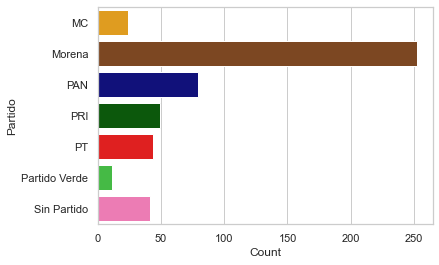

In [266]:
congresspeople_per_party_plot = sns.barplot(x="Count", y="Partido", data=congresspeople_per_party, palette=party_color_palette)


### Education levels

In [224]:
congresspeople_per_education_lvl = congress_df.groupby('Escolaridad')['ID'].count().reset_index(name='Count')
congresspeople_per_education_lvl

,Escolaridad,Count
0,Bachillerato,37
1,Doctorado,25
2,Licenciatura,213
3,Maestría,119
4,Posgrado,6
5,Primaria,2
6,Secundaria,12
7,Sin estudios registrados,86


<AxesSubplot:xlabel='Escolaridad', ylabel='Count'>

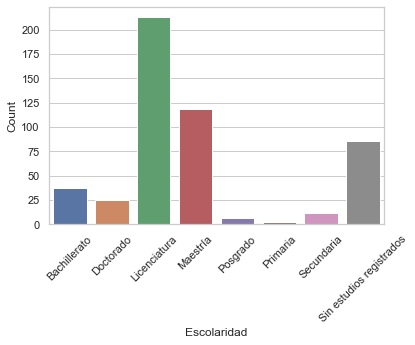

In [267]:
education_lvl_plt = sns.barplot(x="Escolaridad", y="Count", data=congresspeople_per_education_lvl)
for item in education_lvl_plt.get_xticklabels():
    item.set_rotation(45)
education_lvl_plt

In [225]:
education_lvl_per_party = congress_df.groupby(['Partido', 'Escolaridad'])['ID'].count().reset_index(name='Count')
education_lvl_per_party

,Partido,Escolaridad,Count
0,MC,Bachillerato,1
1,MC,Doctorado,2
2,MC,Licenciatura,13
3,MC,Maestría,5
4,MC,Sin estudios registrados,3
5,Morena,Bachillerato,26
6,Morena,Doctorado,8
7,Morena,Licenciatura,111
8,Morena,Maestría,42
9,Morena,Posgrado,3


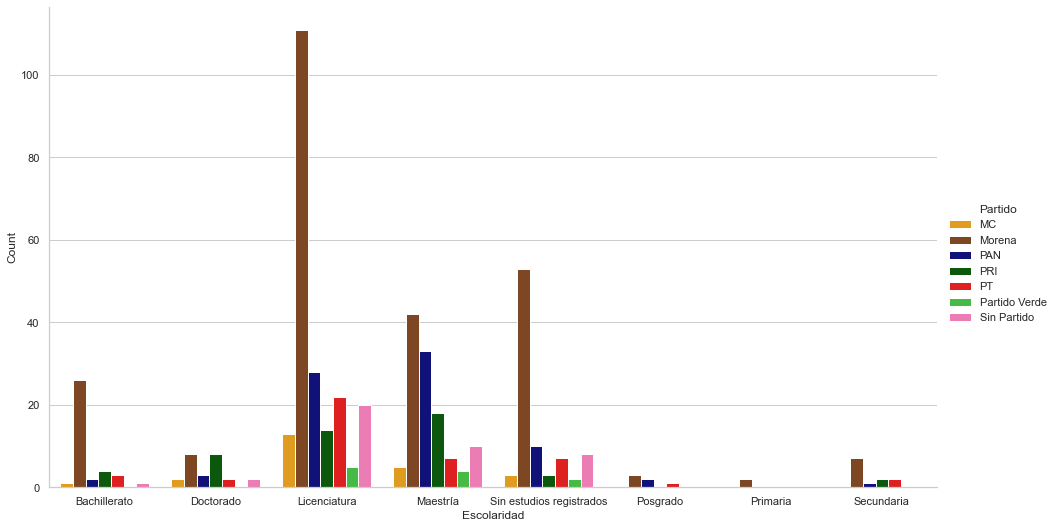

In [273]:
education_lvl_per_party_plt = sns.catplot(data=education_lvl_per_party, kind="bar", x="Escolaridad", y="Count", hue="Partido", palette=party_color_palette, height=7.5, aspect=16/9)

### Proposals by party 

In [307]:
proposals_df = congress_df[['ID', 'Nombre', 'Partido', 'Escolaridad', 'Propuestas_TOTAL', 'Propuestas aprobadas_TOTAL']]
proposals_df

,ID,Nombre,Partido,Escolaridad,Propuestas_TOTAL,Propuestas aprobadas_TOTAL
0,286958853641361825227662389305295482505,Pedro Daniel Abasolo Sánchez,PT,Secundaria,24,12
1,17008674771083780873293814831134376713,Brasil Alberto Acosta Peña,PRI,Doctorado,73,11
2,210176292887365193795612777553345542615,Marco Antonio Adame Castillo,PAN,Maestría,164,21
3,269882339652188138864988740215102620899,Heriberto Marcelo Aguilar Castillo,Morena,Licenciatura,53,16
4,104934072240793553085582246887485956431,Ricardo Aguilar Castillo,PRI,Licenciatura,67,10
...,...,...,...,...,...,...
495,221110123247283364997927248645698103951,Claudia Valeria Yáñez Centeno y Cabrera,Morena,Sin estudios registrados,60,21
496,146184305166259539636440112658808209097,Casimiro Zamora Valdez,Morena,Licenciatura,49,16
497,196945503096515986598393565700536499242,Martha Angélica Zamudio Macias,MC,Bachillerato,77,9
498,136012118747114497112167327430119282081,Graciela Zavaleta Sánchez,Morena,Primaria,48,19


In [308]:
proposals_by_party = proposals_df.groupby('Partido')[['Propuestas_TOTAL', 'Propuestas aprobadas_TOTAL']].sum().reset_index()
proposals_by_party

,Partido,Propuestas_TOTAL,Propuestas aprobadas_TOTAL
0,MC,2362,325
1,Morena,12414,4159
2,PAN,11782,1595
3,PRI,3344,543
4,PT,2206,395
5,Partido Verde,1550,337
6,Sin Partido,3190,492


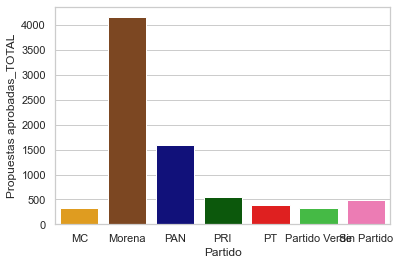

In [309]:
approved_proposals_by_party = sns.barplot(x='Partido', y='Propuestas aprobadas_TOTAL', data=proposals_by_party, palette=party_color_palette)


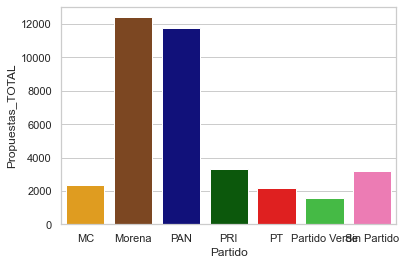

In [310]:
total_proposals_by_party = sns.barplot(x='Partido', y='Propuestas_TOTAL', data=proposals_by_party, palette=party_color_palette)

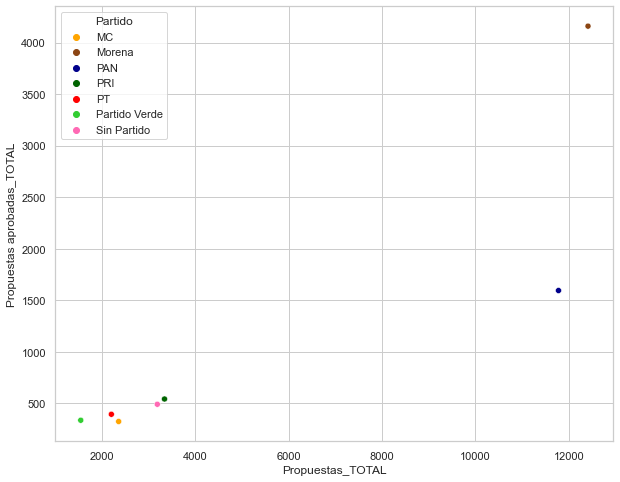

In [311]:
approved_vs_total_proposals_by_party = sns.scatterplot(data=proposals_by_party, x='Propuestas_TOTAL', y="Propuestas aprobadas_TOTAL", hue="Partido", palette=party_color_palette)
plt.gcf().set_size_inches(10,8)

### Proposals by level of education

In [312]:
proposals_by_education_lvl = proposals_df.groupby('Escolaridad')[['Propuestas_TOTAL', 'Propuestas aprobadas_TOTAL']].sum().reset_index()
proposals_by_education_lvl

,Escolaridad,Propuestas_TOTAL,Propuestas aprobadas_TOTAL
0,Bachillerato,1876,528
1,Doctorado,2350,402
2,Licenciatura,15029,3394
3,Maestría,11470,2074
4,Posgrado,579,126
5,Primaria,87,35
6,Secundaria,638,180
7,Sin estudios registrados,4819,1107


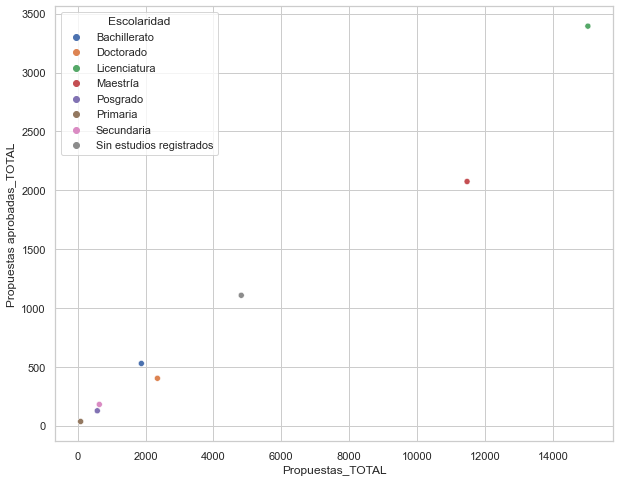

In [315]:
approved_vs_total_proposals_by_education_lvl = sns.scatterplot(data=proposals_by_education_lvl, x='Propuestas_TOTAL', y="Propuestas aprobadas_TOTAL", hue="Escolaridad")
plt.gcf().set_size_inches(10,8)